# BTC Predictor

In [718]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [719]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
from ta import *

PATH='data/stock/'

## Create datasets

You can download the datasets used [here](https://www.kaggle.com/c/titanic/data).

Feature Space:
* train: Training set provided by competition
* test: testing set

In [720]:
table_names = ['btc-bitstamp-2012-01-01_to_2018-01-08']

We'll be using the popular data manipulation framework `pandas`. Among other things, pandas allows you to manipulate tables/data frames in python as one would in a database.

We're going to go ahead and load all of our csv's as dataframes into the list `tables`.

In [721]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [722]:
from IPython.display import HTML

We can use `head()` to get a quick look at the contents of each table:
* train: Contains Passenger info such as Gender, Age, Ticket, Fare and whether Survived, the prediction variable
* test: Same as training table, w/o Survived


In [723]:
for t in tables: display(t.head())

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


The following returns summarized aggregate information to each table accross each field.

In [724]:
# for t in tables: display(DataFrameSummary(t).summary())

## Data Cleaning / Feature Engineering

As a structured data problem, we necessarily have to go through all the cleaning and feature engineering, even though we're using a neural network.

In [725]:
train= tables[0]

In [726]:
len(train)

3161057

Time modifications

In [727]:
#convert to date objects
train["Timestamp"] = pd.to_datetime(train["Timestamp"], unit='s')
train['hour'] = train.Timestamp.dt.hour;
train['minute'] = train.Timestamp.dt.minute;
train.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,hour,minute
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,7,52
1,2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,7,53
2,2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,7,54
3,2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,7,55
4,2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,7,56


SET DEPENDENT VARIABLE ACTION

In [728]:
lookahead = 90
percentIncrease = 1.005
train['action'] =  train['Close'].rolling(window=lookahead).max() > percentIncrease * train['Close']

# train['action'] = 0;
# train.loc[train['Close'].rolling(window=lookahead).max() > train['Close'], 'action'] = 1
# train.loc[train['Close'].rolling(window=lookahead).max() > percentIncrease * train['Close'], 'action'] = 2

train.action = train.action.astype(int)

# target count by category
len(train[train.action==2]),len(train[train.action==1]),len(train[train.action==0])

(0, 1101545, 2059512)

In [729]:
# edit columns
train["VolumeBTC"] = train["Volume_(BTC)"]
train.drop('Volume_(BTC)',1,inplace=True)
train["VolumeCurrency"] = train["Volume_(Currency)"]
train.drop('Volume_(Currency)',1,inplace=True)
train["WeightedPrice"] = train["Weighted_Price"]
train.drop('Weighted_Price',1,inplace=True)

# delete unused columns
train.drop('VolumeCurrency',1,inplace=True)
train.head()

,Timestamp,Open,High,Low,Close,hour,minute,action,VolumeBTC,WeightedPrice
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,7,52,0,0.455581,4.39
1,2011-12-31 07:53:00,4.39,4.39,4.39,4.39,7,53,0,0.455581,4.39
2,2011-12-31 07:54:00,4.39,4.39,4.39,4.39,7,54,0,0.455581,4.39
3,2011-12-31 07:55:00,4.39,4.39,4.39,4.39,7,55,0,0.455581,4.39
4,2011-12-31 07:56:00,4.39,4.39,4.39,4.39,7,56,0,0.455581,4.39


In [730]:
# trim to x records for now
# TODO: remove this
train = train.tail(260000)
len(train)

260000

In [731]:
# remove all 0 values 
train = train[train.Open!=0]
train = train[train.High!=0]
train = train[train.Low!=0]
train = train[train.Close!=0]
train = train[train.WeightedPrice!=0]
train = train[train.VolumeBTC!=0]
len(train)

259999

In [732]:
# add technical analysis
train = add_all_ta_features(train, "Open", "High", "Low", "Close", "VolumeBTC", fillna=False)

In [733]:
# add all date time values
add_datepart(train, "Timestamp", drop=False)

Create test set

In [734]:
# todo: make this into a percentage instead of hardcoding the test set
test = train.tail(10000)
test.reset_index(inplace=True)
train = train.head(250000)
train.reset_index(inplace=True)
len(train),len(test)

(250000, 10000)

In [735]:
train.to_feather(f'{PATH}train')
test.to_feather(f'{PATH}test')

## Create features

In [736]:
train = pd.read_feather(f'{PATH}train')
test = pd.read_feather(f'{PATH}test')

In [737]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
train.tail(50).T.head(100)

,249970,249971,249972,249973,249974,249975,249976,249977,249978,249979,249980,249981,249982,249983,249984,249985,249986,249987,249988,249989,249990,249991,249992,249993,249994,249995,249996,249997,249998,249999
index,3151028,3151029,3151030,3151031,3151032,3151033,3151034,3151035,3151036,3151037,3151038,3151039,3151040,3151041,3151042,3151043,3151044,3151045,3151046,3151047,3151048,3151049,3151050,3151051,3151052,3151053,3151054,3151055,3151056,3151057
Timestamp,2018-01-01 00:52:00,2018-01-01 00:53:00,2018-01-01 00:54:00,2018-01-01 00:55:00,2018-01-01 00:56:00,2018-01-01 00:57:00,2018-01-01 00:58:00,2018-01-01 00:59:00,2018-01-01 01:00:00,2018-01-01 01:01:00,2018-01-01 01:02:00,2018-01-01 01:03:00,2018-01-01 01:04:00,2018-01-01 01:05:00,2018-01-01 01:06:00,2018-01-01 01:07:00,2018-01-01 01:08:00,2018-01-01 01:09:00,2018-01-01 01:10:00,2018-01-01 01:11:00,2018-01-01 01:12:00,2018-01-01 01:13:00,2018-01-01 01:14:00,2018-01-01 01:15:00,2018-01-01 01:16:00,2018-01-01 01:17:00,2018-01-01 01:18:00,2018-01-01 01:19:00,2018-01-01 01:20:00,2018-01-01 01:21:00
Open,13732.8,13704.5,13693.6,13668.5,13622,13601,13628.5,13633.6,13635.1,13636.1,13678.9,13656,13675.4,13676.1,13679.5,13660,13600,13608,13587,13567,13614,13600,13600,13600,13567.8,13597,13643.9,13642.9,13675.2,13694.1
High,13733.1,13704.5,13693.6,13668.5,13630,13630,13651.9,13668.5,13681.4,13678.9,13680,13675.6,13676.1,13680,13679.7,13679.6,13610.2,13609.8,13595.4,13614,13614.1,13600,13600,13600,13599,13647,13643.9,13675.3,13694.1,13694.1
Low,13669.6,13668.5,13690.8,13622,13600.3,13601,13601,13633.6,13635.1,13636.1,13656,13656,13657,13660,13660,13600,13598,13564,13564,13564.1,13585.3,13565.7,13600,13565.2,13564.1,13576.3,13604.7,13605,13647.5,13694.1
Close,13669.6,13704.5,13690.8,13622,13630,13623.4,13651.8,13668.5,13681.4,13678.9,13656,13674.7,13676.1,13666.7,13660,13600,13610.2,13574,13567,13614,13614.1,13600,13600,13599,13597,13645,13618.5,13647.5,13694.1,13694.1
hour,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
minute,52,53,54,55,56,57,58,59,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
action,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
VolumeBTC,1.27812,0.109093,0.0459614,13.2409,1.02044,0.19926,2.3952,1.49931,0.531898,9.46679,1.30616,1.14318,0.179416,0.860276,1.26541,8.65339,3.09669,15.4342,4.19633,1.03008,1.24946,0.272052,0.0454431,0.384441,0.885178,4.08005,0.283713,12.4654,18.4473,0.182504


In [738]:
# display(DataFrameSummary(train).summary())
# break break break now

Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

In [739]:
train.head()

,index,Timestamp,Open,High,Low,Close,hour,minute,action,VolumeBTC,WeightedPrice,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_cr,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,TimestampElapsed
0,2901057,2017-07-11 10:41:00,2343.46,2343.46,2335.02,2335.02,10,41,1,4.843332,2336.999820,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,1000.000000,8.440000,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.000000,0.000000,2335.020000,2335.020000,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,2017,7,28,11,1,192,False,False,False,False,False,False,1499769660
1,2901058,2017-07-11 10:42:00,2343.31,2343.31,2335.04,2335.65,10,42,1,10.780731,2336.489413,-14.033677,10.780731,NaN,NaN,NaN,NaN,NaN,1000.000000,8.362414,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.006657,0.003503,0.003153,2335.347600,2335.340943,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,0.026980,0.026980,2017,7,28,11,1,192,False,False,False,False,False,False,1499769720
2,2901059,2017-07-11 10:43:00,2335.65,2342.80,2335.02,2335.02,10,43,1,12.944384,2335.403051,-22.134729,-12.944384,NaN,NaN,0.000000,NaN,-0.000583,1000.000000,8.154739,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,-0.000348,0.002082,-0.002430,2335.229552,2335.229900,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.275862,NaN,47.131445,NaN,NaN,NaN,NaN,NaN,-0.026973,0.000000,2017,7,28,11,1,192,False,False,False,False,False,False,1499769780
3,2901060,2017-07-11 10:44:00,2335.00,2335.01,2335.00,2335.01,10,44,1,1.550654,2335.009887,-11.393729,-1.550654,NaN,NaN,5.907249,NaN,-0.003498,999.995717,5.906009,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,-0.003866,0.000353,-0.004218,2335.167909,2335.171775,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.854901,NaN,33.705392,NaN,NaN,NaN,NaN,NaN,-0.000428,-0.000428,2017,7,28,11,1,192,False,False,False,False,False,False,1499769840
4,2901061,2017-07-11 10:45:00,2336.00,2339.35,2336.00,2336.01,10,45,1,7.062206,2336.226666,-5.469389,7.062206,NaN,NaN,-5.823356,NaN,0.003018,999.995717,5.548171,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.012000,0.003197,0.008803,2335.364306,2335.352307,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.041552,NaN,36.913229,NaN,NaN,NaN,NaN,NaN,0.042826,0.042398,2017,7,28,11,1,192,False,False,False,False,False,False,1499769900


Identify categorical vs continuous variables.  PassengerId serves as the unique identifier for each row.

In [740]:
cat_vars = ['TimestampYear', 'TimestampMonth', 'TimestampWeek', 'TimestampDay', 'hour','minute', 'TimestampDayofweek',
'TimestampDayofyear','TimestampIs_month_end', 'TimestampIs_month_start', 'TimestampIs_quarter_end',
'TimestampIs_quarter_start','TimestampIs_year_end', 'TimestampIs_year_start']

contin_vars = ['Open', 'Close','High', 'Low', 'VolumeBTC', 'WeightedPrice', 'TimestampElapsed',
'volume_adi','volume_obv','volume_nvi','volatility_bbh','volatility_bbl','volatility_atr','volatility_bbm'
,'trend_adx_pos','momentum_rsi','momentum_stoch','trend_ichimoku_a','trend_ichimoku_b','trend_mass_index']
# , 'volume_obvm','volume_fi','volume_em','volume_vpt',
#                'trend_adx_neg','volume_cmf','volume_nvi'

index='Timestamp'
dep = 'action'
n = len(train); n

test = test.set_index(index)
train = train.set_index(index)
   

In [741]:
train = train[cat_vars+contin_vars+[dep]].copy()
# , index

In [742]:
# test[dep] = 0 
test = test[cat_vars+contin_vars+[dep]].copy()
# , index


In [743]:
for v in cat_vars: train[v] = train[v].astype('category').cat.as_ordered()

In [744]:
apply_cats(test, train)
# test

In [745]:
for v in contin_vars:
    train[v] = train[v].astype('float32')
    test[v] = test[v].astype('float32')

We can now process our data...

In [746]:
df, y, nas, mapper = proc_df(train, dep, do_scale=True)

In [747]:
y.shape


(250000,)

In [748]:
df_test, _, nas, mapper = proc_df(test, dep, do_scale=True, mapper=mapper, na_dict=nas)
train.head(30).T.head(70)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,VolumeBTC,WeightedPrice,TimestampElapsed,volume_adi,volume_obv,volume_nvi,volatility_bbh,volatility_bbl,volatility_atr,volatility_bbm,trend_adx_pos,momentum_rsi,momentum_stoch,trend_ichimoku_a,trend_ichimoku_b,trend_mass_index,action
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-07-11 10:41:00,2017,7,28,11,10,41,1,192,False,False,False,False,False,False,2343.459961,2335.020020,2343.459961,2335.020020,4.843331,2336.999756,1.499770e+09,NaN,0.000000,1.000000e+03,NaN,NaN,8.440000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2017-07-11 10:42:00,2017,7,28,11,10,42,1,192,False,False,False,False,False,False,2343.310059,2335.649902,2343.310059,2335.040039,10.780731,2336.489502,1.499770e+09,-14.033677,10.780731,1.000000e+03,NaN,NaN,8.362413,NaN,NaN,100.000000,NaN,NaN,NaN,NaN,1
2017-07-11 10:43:00,2017,7,28,11,10,43,1,192,False,False,False,False,False,False,2335.649902,2335.020020,2342.800049,2335.020020,12.944384,2335.403076,1.499770e+09,-22.134729,-12.944384,1.000000e+03,NaN,NaN,8.154738,NaN,NaN,48.275864,NaN,NaN,NaN,NaN,1
2017-07-11 10:44:00,2017,7,28,11,10,44,1,192,False,False,False,False,False,False,2335.000000,2335.010010,2335.010010,2335.000000,1.550654,2335.009766,1.499770e+09,-11.393729,-1.550654,9.999957e+02,NaN,NaN,5.906009,NaN,NaN,47.854900,NaN,NaN,NaN,NaN,1
2017-07-11 10:45:00,2017,7,28,11,10,45,1,192,False,False,False,False,False,False,2336.000000,2336.010010,2339.350098,2336.000000,7.062206,2336.226562,1.499770e+09,-5.469389,7.062206,9.999957e+02,NaN,NaN,5.548172,NaN,NaN,73.041550,NaN,NaN,NaN,NaN,1
2017-07-11 10:46:00,2017,7,28,11,10,46,1,192,False,False,False,False,False,False,2339.479980,2340.000000,2340.000000,2337.010010,7.524592,2339.663818,1.499770e+09,0.504548,7.524592,9.999957e+02,NaN,NaN,5.241720,NaN,NaN,91.204056,NaN,NaN,NaN,NaN,1
2017-07-11 10:47:00,2017,7,28,11,10,47,1,192,False,False,False,False,False,False,2340.000000,2338.000000,2340.000000,2338.000000,3.848164,2338.543457,1.499770e+09,3.676428,-3.848164,9.991410e+02,NaN,NaN,4.677510,NaN,NaN,66.971832,NaN,NaN,NaN,NaN,1
2017-07-11 10:48:00,2017,7,28,11,10,48,1,192,False,False,False,False,False,False,2339.989990,2338.010010,2340.000000,2338.000000,31.065666,2338.157715,1.499770e+09,-34.603172,31.065666,9.991410e+02,NaN,NaN,4.256687,NaN,NaN,67.018776,NaN,NaN,NaN,NaN,1
2017-07-11 10:49:00,2017,7,28,11,10,49,1,192,False,False,False,False,False,False,2339.620117,2339.989990,2340.000000,2339.350098,16.066828,2339.973877,1.499770e+09,-15.182545,16.066828,9.999872e+02,NaN,NaN,3.929999,NaN,NaN,74.659546,NaN,NaN,NaN,NaN,1


In [749]:
nas={}

In [750]:
df.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,VolumeBTC,WeightedPrice,TimestampElapsed,volume_adi,volume_obv,volume_nvi,volatility_bbh,volatility_bbl,volatility_atr,volatility_bbm,trend_adx_pos,momentum_rsi,momentum_stoch,trend_ichimoku_a,trend_ichimoku_b,trend_mass_index,volume_adi_na,volatility_bbh_na,volatility_bbl_na,volatility_bbm_na,trend_adx_pos_na,momentum_rsi_na,momentum_stoch_na,trend_ichimoku_a_na,trend_ichimoku_b_na,trend_mass_index_na
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-07-11 10:41:00,1,2,2,11,11,42,2,2,1,1,1,1,1,1,-0.993824,-0.995756,-0.993862,-0.995793,-0.286344,-0.995304,-1.732056,-0.039904,-0.001660,-0.392681,-0.467215,-0.463574,-0.416877,-0.465529,-0.155938,-0.003569,0.076009,-0.465445,-0.465564,-0.00623,499.999,114.703508,114.703508,114.703508,133.626879,499.999,138.671443,70.006862,56.971513,81.104546
2017-07-11 10:42:00,1,2,2,11,11,43,2,2,1,1,1,1,1,1,-0.993859,-0.995609,-0.993897,-0.995788,0.005042,-0.995422,-1.732026,-0.542470,0.473173,-0.392681,-0.467215,-0.463574,-0.420817,-0.465529,-0.155938,4.632202,0.076009,-0.465445,-0.465564,-0.00623,-0.002,114.703508,114.703508,114.703508,133.626879,-0.002,138.671443,70.006862,56.971513,81.104546


In [751]:
df_test.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,VolumeBTC,WeightedPrice,TimestampElapsed,volume_adi,volume_obv,volume_nvi,volatility_bbh,volatility_bbl,volatility_atr,volatility_bbm,trend_adx_pos,momentum_rsi,momentum_stoch,trend_ichimoku_a,trend_ichimoku_b,trend_mass_index,volume_adi_na,volatility_bbh_na,volatility_bbl_na,volatility_bbm_na,trend_adx_pos_na,momentum_rsi_na,momentum_stoch_na,trend_ichimoku_a_na,trend_ichimoku_b_na,trend_mass_index_na
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:21:00,2,1,1,1,2,22,1,1,1,2,1,2,1,2,1.642641,1.642689,1.638379,1.648062,-0.515081,1.643119,1.732048,0.586002,0.006378,5.773385,1.624162,1.631944,1.111301,1.628094,0.284534,0.721744,1.319180,1.643008,1.654013,-0.230983,-0.002,-0.008718,-0.008718,-0.008718,-0.007484,-0.002,-0.007211,-0.014284,-0.017553,-0.01233
2018-01-01 01:22:00,2,1,1,1,2,23,1,1,1,2,1,2,1,2,1.642648,1.644814,1.640770,1.640595,-0.504311,1.641414,1.732048,-0.038196,0.016044,5.773385,1.626072,1.631110,1.124441,1.628643,0.181060,0.842133,1.294055,1.640477,1.651403,-0.172019,-0.002,-0.008718,-0.008718,-0.008718,-0.007484,-0.002,-0.007211,-0.014284,-0.017553,-0.01233


Rake the last x% of rows as our validation set.

In [752]:
train_ratio = 0.9
train_size = int(n * train_ratio); train_size
val_idx = list(range(train_size, len(df)))
#val_idx = list(range(0, len(df)-train_size))
#val_idx = get_cv_idxs(n, val_pct=0.1)

In [753]:
len(val_idx)

25000

## DL

We're ready to put together our models.

We can create a ModelData object directly from our data frame. Is_Reg is set to False to turn this into a classification problem (from a regression).  Is_multi is set True because there there are three labels for target BUY,HOLD,SELL

In [754]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype('int'), cat_flds=cat_vars, bs=64,
                                      is_reg=False,is_multi=False,test_df=df_test)

Some categorical variables have a lot more levels than others.

In [755]:
cat_sz = [(c, len(train[c].cat.categories)+1) for c in cat_vars]

In [756]:
cat_sz

[('TimestampYear', 3),
 ('TimestampMonth', 8),
 ('TimestampWeek', 27),
 ('TimestampDay', 32),
 ('hour', 25),
 ('minute', 61),
 ('TimestampDayofweek', 8),
 ('TimestampDayofyear', 176),
 ('TimestampIs_month_end', 3),
 ('TimestampIs_month_start', 3),
 ('TimestampIs_quarter_end', 3),
 ('TimestampIs_quarter_start', 3),
 ('TimestampIs_year_end', 3),
 ('TimestampIs_year_start', 3)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [757]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [758]:
emb_szs

[(3, 2),
 (8, 4),
 (27, 14),
 (32, 16),
 (25, 13),
 (61, 31),
 (8, 4),
 (176, 50),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2)]

Check if cuda is available

In [759]:
torch.cuda.is_available()

True

In [760]:
len(df.columns)-len(cat_vars)

30

In [761]:
dropout = 0.06
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),dropout, 2, [100,50], [0.03,0.06],None,True)

In [762]:
m

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(3, 2)
    (1): Embedding(8, 4)
    (2): Embedding(27, 14)
    (3): Embedding(32, 16)
    (4): Embedding(25, 13)
    (5): Embedding(61, 31)
    (6): Embedding(8, 4)
    (7): Embedding(176, 50)
    (8): Embedding(3, 2)
    (9): Embedding(3, 2)
    (10): Embedding(3, 2)
    (11): Embedding(3, 2)
    (12): Embedding(3, 2)
    (13): Embedding(3, 2)
  )
  (lins): ModuleList(
    (0): Linear(in_features=176, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=50, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=50, out_features=2, bias=True)
  (emb_drop): Dropout(p=0.06)
  (drops): ModuleList(
    (0): Dropout(p=0.03)
    (1): Dropout(p=0.06)
  )
  (bn): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True)
)

 70%|███████   | 2463/3516 [00:15<00:06, 157.70it/s, loss=1.36] 

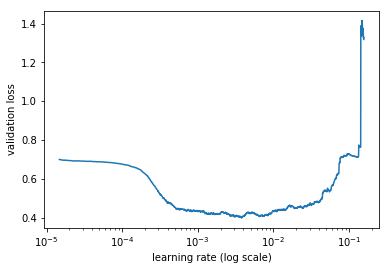

In [763]:
m.lr_find()
m.sched.plot(100)
lr = 1e-5

In [764]:
m.fit(lr, 3)

epoch      trn_loss   val_loss                                  
    0      0.652891   0.617359  
    1      0.567982   0.54194                                   
    2      0.48125    0.461947                                  


[array([0.46195])]

In [765]:
m.fit(lr, 5, cycle_len=1)

epoch      trn_loss   val_loss                                  
    0      0.456178   0.435007  
    1      0.458404   0.41341                                   
    2      0.446628   0.39961                                   
    3      0.440691   0.386802                                  
    4      0.428491   0.378403                                  


[array([0.3784])]

In [766]:
m.fit(lr, 3, cycle_len=4, cycle_mult=2 )

epoch      trn_loss   val_loss                                  
    0      0.430152   0.369063  
    1      0.423146   0.36534                                   
    2      0.419805   0.361883                                  
    3      0.422313   0.36193                                   
    4      0.421932   0.355743                                  
    5      0.41923    0.353365                                  
    6      0.405813   0.351908                                  
    7      0.41263    0.349707                                  
    8      0.405277   0.348416                                  
    9      0.408588   0.3476                                    
    10     0.418181   0.3476                                    
    11     0.417846   0.34758                                   
    12     0.397985   0.341151                                  
    13     0.412326   0.344972                                  
    14     0.410015   0.344707                           

[array([0.35369])]

In [767]:
m.save('btcBinaryClassificationModel')

In [768]:
m.load('btcBinaryClassificationModel')

## Validation

In [769]:
def calculateAccuracy(valpred):
    successfulPredictions = valpred.loc[valpred.action == valpred.predicted]
    # total accuracy does not provide an accurate represantation
    # totalAccuracy = len(successfulPredictions)/len(valpred)
    totalBuyActions = valpred.loc[valpred.action == 1]
    totalSellActions = valpred.loc[valpred.action == 0]
    successfulBuyPredictions = successfulPredictions.loc[successfulPredictions.action == 1]
    successfulSellPredictions = successfulPredictions.loc[successfulPredictions.action == 0]
    buyAccuracy = len(successfulBuyPredictions)/len(totalBuyActions)
    sellAccuracy = len(successfulSellPredictions)/len(totalSellActions)
    result = {
        'F1Score': (buyAccuracy + sellAccuracy )/2,
        'buyAccuracy': buyAccuracy,
        'sellAccuracy': sellAccuracy,
        'totalBuyActions': len(totalBuyActions),
        'successfulBuyPredictions': len(successfulBuyPredictions)
    }
    return result


In [770]:
(x,y1)=m.predict_with_targs()

Predicted vs Validation

In [771]:
(np.argmax(x,axis=1),y1)

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]))

In [772]:
y1.shape


(25000,)

In [787]:
val = train.iloc[val_idx]
val[[dep]]
valpred = pd.DataFrame({'Close':val.Close,'index':val.index, 'action':val.action, 'predicted':np.argmax(x,axis=1)})[['Close','index', 'action','predicted']]
valpred.tail(10)

,Close,index,action,predicted
Timestamp,,,,
2018-01-01 01:12:00,13614.059570,2018-01-01 01:12:00,1,1
2018-01-01 01:13:00,13600.000000,2018-01-01 01:13:00,1,1
2018-01-01 01:14:00,13600.000000,2018-01-01 01:14:00,1,1
2018-01-01 01:15:00,13599.000000,2018-01-01 01:15:00,1,1
2018-01-01 01:16:00,13597.000000,2018-01-01 01:16:00,1,1
2018-01-01 01:17:00,13644.959961,2018-01-01 01:17:00,1,1
2018-01-01 01:18:00,13618.469727,2018-01-01 01:18:00,1,1
2018-01-01 01:19:00,13647.469727,2018-01-01 01:19:00,1,1
2018-01-01 01:20:00,13694.089844,2018-01-01 01:20:00,1,1


Calculate the percent accuracy on the validation set

In [774]:
calculateAccuracy(valpred)

{'F1Score': 0.7285486891385767,
 'buyAccuracy': 0.9687640449438202,
 'sellAccuracy': 0.48833333333333334,
 'totalBuyActions': 17800,
 'successfulBuyPredictions': 17244}

## Test

In [775]:
np.argmax(m.predict(True), axis =1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [776]:
testPred = pd.DataFrame({'Timestamp':test.index, 'Close':test.Close, 'action':test.action, 'predicted':np.argmax(m.predict(True), axis =1)})[['Close','Timestamp', 'action', 'predicted']]
testPred.head(10)

,Close,Timestamp,action,predicted
Timestamp,,,,
2018-01-01 01:21:00,13694.110352,2018-01-01 01:21:00,1,1
2018-01-01 01:22:00,13703.259766,2018-01-01 01:22:00,1,1
2018-01-01 01:23:00,13690.679688,2018-01-01 01:23:00,1,1
2018-01-01 01:24:00,13651.230469,2018-01-01 01:24:00,1,1
2018-01-01 01:25:00,13651.250000,2018-01-01 01:25:00,1,1
2018-01-01 01:26:00,13651.250000,2018-01-01 01:26:00,1,1
2018-01-01 01:27:00,13651.219727,2018-01-01 01:27:00,1,1
2018-01-01 01:28:00,13650.990234,2018-01-01 01:28:00,1,1
2018-01-01 01:29:00,13651.000000,2018-01-01 01:29:00,1,1


Calculate the percent accuracy on the test set

In [777]:
calculateAccuracy(testPred)

{'F1Score': 0.5414416085344266,
 'buyAccuracy': 0.9997033521210323,
 'sellAccuracy': 0.08317986494782074,
 'totalBuyActions': 6742,
 'successfulBuyPredictions': 6740}

In [778]:
# csv_fn=f'{PATH}/tmp/sub4.csv'
# sub.to_csv(csv_fn, index=False)
# FileLink(csv_fn)

## Random Forest

In [779]:
from sklearn.ensemble import RandomForestRegressor

In [780]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, y)

In [781]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

In [782]:
def PredtoClass(a):
    pred_class = []
    for i in range(len(a)):
        if a[i]<.5:
            pred_class.append(0)
        else:
            pred_class.append(1)
    return pred_class
def accuracy(preds, y_val):
    return  sum(1- abs(PredtoClass(preds) - y_val))/len(y_val)

Accuracy on the validation set using a Random Forest Regressor

In [783]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, accuracy(preds, y_val)

(0.9388966360435095, 0.47687014606564515, 0.727608548314649, 0.85292)

In [784]:
preds_test = m.predict(df_test.values)

In [785]:
sub = pd.DataFrame({'Timestamp':test.index, 'action':PredtoClass(preds_test)})[['Timestamp', 'action']]
sub.head(10)

,Timestamp,action
0,2018-01-01 01:21:00,1
1,2018-01-01 01:22:00,0
2,2018-01-01 01:23:00,0
3,2018-01-01 01:24:00,1
4,2018-01-01 01:25:00,1
5,2018-01-01 01:26:00,1
6,2018-01-01 01:27:00,1
7,2018-01-01 01:28:00,1
8,2018-01-01 01:29:00,1
9,2018-01-01 01:30:00,1


In [786]:
# csv_fn=f'{PATH}/tmp/RFsub5.csv'
# sub.to_csv(csv_fn, index=False)
# FileLink(csv_fn)